# Lab 6-3  Surface Temperatures 

In [11]:
# import libraries we'll need
import urllib
import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline

## User-provided inputs

Here we define a few variables to be used in the notebook. You may or may not want to change these values.

In [2]:
# Provide the path to a directory you want to download the SoS files to
download_directory = './sosnoqc/'

# Provide a the start and end dates you want to download
start_date = '20230131'
end_date = '20230202'

# Provide the specific variables you want to extract from the dataset.
# We provide these in advance because the datasets are very large and, 
# when we open them, we want to immediately extract only the data we want.
# Right now we want the temperature recordings from in the snowpack... or we hope are in the snowpack...
# These are available next to the upwind (uw) tower and the downwind (d) tower.
# For comparison, we also download the 2 m air temperature from the central tower (c).
VARIABLES = [
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",
    "Rpile_out_9m_d",
    "Tcase_out_9m_d",   
]

### Download SoS NetCDF files from an NCAR FTP server

Define a function for downloading daily SoS NetCDF filesm

In [3]:
def download_sos_data_day(date, local_download_dir, cache=True):
    """Download a netcdf file from the ftp url provided by the Earth Observing 
    Laboratory at NCAR. Data comes in one NetCDF file per day, Reynolds-Averaged 
    with a 5-minute averaging period.

    Args:
        date (str, optional): String representing a date in format '%Y%m%d'. Defaults to '20221101'.
        local_download_dir (str, optional): Directory to which files will be downloaded. Defaults 
                    to 'sosnoqc'; this directory will be created if it  does not already exist.
        cache (bool, optional): If True, looks in `local_download_dir` for requested  file, if it 
                    exists, does not redownload file. If False, downloads file from the FTP server.

    Returns:
        _type_: Relative path to the downloaded file
    """
    base_url = 'ftp.eol.ucar.edu'
    path = 'pub/archive/isfs/projects/SOS/netcdf/noqc_geo'
    file = f'isfs_{date}.nc'
    os.makedirs(local_download_dir, exist_ok=True)
    full_file_path = os.path.join('ftp://', base_url, path, file)
    download_file_path = os.path.join(local_download_dir, file)
    if cache and os.path.isfile(download_file_path):
        print(f"Caching...skipping download for {date}")
    else:
        urllib.request.urlretrieve(
            full_file_path,
            download_file_path   
        )
    return download_file_path

Use the function defined above to download all the files we specified. When you run the cell below this comment, this will ~3-5 minutes if you are downloading more than a few days.

In [4]:
# Create a list of datetime objects for every day between the provided start_date and end_date. 
datelist = pd.date_range(
    dt.datetime.strptime(start_date, '%Y%m%d'),
    dt.datetime.strptime(end_date, '%Y%m%d'),
    freq='d'
).strftime('%Y%m%d').tolist()

# Download one daily file for each date in the datelist. 
# cache = True so that when we rerun the notebook in the future, we don't have to redownload the data.
files = [download_sos_data_day(date, download_directory, cache=True) for date in datelist]

Caching...skipping download for 20230131
Caching...skipping download for 20230201
Caching...skipping download for 20230202


### Open and and concatenate SoS datasets with Xarray

Note that as we open each individual file, we extract only the VARIABLES we defined above.  This may also take some time.

In [5]:
# Open up one day's dataset. We open this single dataset and keep all variables, so we can check out all that is available
example_complete_dataset = xr.open_dataset(files[0])

# Open up datasets from every day, extracting our VARIABLES of choice as we open individual datasets. This is so that we have a smaller dataset held 
# in computer memory.
all_datasets = [xr.open_dataset(file)[VARIABLES] for file in files]
sos_dataset = xr.concat(all_datasets, dim='time')

#### Check out our SoS dataset

Note that our `dataset` has just the variables we are defined. Note that `example_complete_dataset` has 1047 variables.

In [6]:
sos_dataset

<xarray.Dataset>
Dimensions:         (time: 864)
Coordinates:
  * time            (time) datetime64[ns] 2023-01-31T00:02:30 ... 2023-02-02T...
Data variables: (12/14)
    Vtherm_c        (time) float32 1.648 1.647 1.647 1.65 ... 1.678 1.652 1.63
    Vtherm_d        (time) float32 1.647 1.646 1.646 1.648 ... 1.703 1.678 1.651
    Vtherm_ue       (time) float32 1.644 1.644 1.645 1.649 ... 1.692 1.669 1.65
    Vtherm_uw       (time) float32 1.647 1.647 1.647 1.651 ... 1.73 1.714 1.695
    Vpile_c         (time) float32 -4.318e-06 -6.366e-06 ... -0.0001237
    Vpile_d         (time) float32 -4.812e-06 -6.703e-06 ... -0.0001186
    ...              ...
    IDir_c          (time) float32 139.0 139.0 139.0 139.0 ... 139.0 139.0 139.0
    IDir_d          (time) float32 137.0 137.0 137.0 137.0 ... 137.0 137.0 137.0
    IDir_ue         (time) float32 136.0 136.0 136.0 136.0 ... 136.0 136.0 136.0
    IDir_uw         (time) float32 140.0 140.0 140.0 140.0 ... 140.0 140.0 140.0
    Rpile_out_9m_d  (time) float32 -9.875 -10.41 -10.51 ... -42.57 -41.89 -43.52
    Tcase_out_9m_d  (time) float32 -5.486 -5.446 -5.417 ... -6.684 -5.927 -5.15
Attributes:
    history:                   Created: 2023-01-31 00:05:12 +0000\n
    NIDAS_version:             v1.2-1692
    calibration_file_path:     /h/eol/isfs/isfs/projects/SOS/ISFS/cal_files/n...
    project_config:            /h/eol/isfs/isfs/projects/SOS/ISFS/config/sos....
    wind3d_horiz_coordinates:  geographic
    file_length_seconds:       86400
    wind3d_horiz_rotation:     1
    wind3d_tilt_correction:    0

In [7]:
# This calculates the surface temperature based on the radiation measured by Eppley Radiometer on the downwind tower
SB = 5.67e-08 # steven boltzman constant, W/m^2/degK^4
SNOW_EMMISIVITY = 0.98
sos_dataset['Tsurf_rad_d'] = ((sos_dataset['Rpile_out_9m_d'] + SB * (sos_dataset['Tcase_out_9m_d']+273.15)**4)/(SNOW_EMMISIVITY*SB))**(1/4) - 273.15

In [13]:
# The function below calculates the surface temperatures from the Apogees
def apogee2temp(ds,tower):
    # hard-coded sensor-specific calibrations
    Vref = 2.5
    ID = ds[f"IDir_{tower}"]
    sns = [136, 137, 138, 139, 140]
    im = [ sns.index(x) if x in sns else None for x in ID ][0]
    # unclear if we want these, or scaled up versions
    mC0 = [57508.575,56653.007,58756.588,58605.7861, 58756.588][im] * 1e5
    mC1 = [289.12189,280.03380,287.12487,285.00285, 287.12487][im] * 1e5
    mC2 = [2.16807,2.11478,2.11822,2.08932, 2.11822][im] * 1e5
    bC0 = [-168.3687,-319.9362,-214.5312,-329.6453, -214.5312][im]* 1e5
    bC1 = [-0.22672,-1.23812,-0.59308,-1.24657, -0.59308][im]* 1e5
    bC2 = [0.08927,0.08612,0.10936,0.09234, 0.10936][im]* 1e5
    # read data
    Vtherm = ds[f"Vtherm_{tower}"]
    Vpile = ds[f"Vpile_{tower}"]*1000
    # calculation of detector temperature from Steinhart-Hart
    Rt = 24900.0/((Vref/Vtherm) - 1)
    Ac = 1.129241e-3
    Bc = 2.341077e-4
    Cc = 8.775468e-8
    TDk = 1/(Ac + Bc*np.log(Rt) + Cc*(np.log(Rt)**3))
    TDc = TDk - 273.15
    # finally, calculation of "target" temperature including thermopile measurement
    m = mC2*TDc**2 + mC1*TDc + mC0
    b = bC2*TDc**2 + bC1*TDc + bC0
    TTc = (TDk**4 + m*Vpile + b)**0.25 - 273.15
    # sufs = suffixes(TTc,leadch='') # get suffixes
    # dimnames(TTc)[[2]] = paste0("Tsfc.Ap.",sufs)
    return TTc

In [14]:
sos_dataset['Tsurf_c'] = (['time'],  apogee2temp(sos_dataset, 'c').values)
sos_dataset['Tsurf_d'] = (['time'],  apogee2temp(sos_dataset, 'd').values)
sos_dataset['Tsurf_ue'] = (['time'], apogee2temp(sos_dataset, 'ue').values)
sos_dataset['Tsurf_uw'] = (['time'], apogee2temp(sos_dataset, 'uw').values)

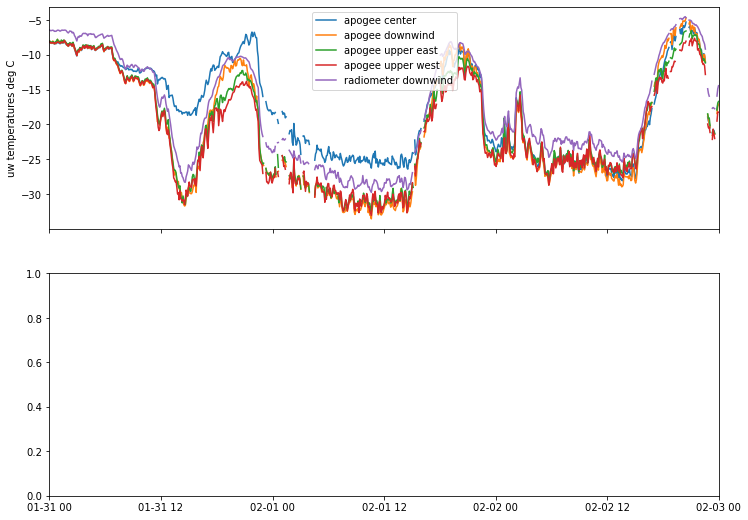

In [17]:
#first, let's make a plot with all of the data, not aggregated to hourly

fig, axes = plt.subplots(2, 1, figsize=(12,9), sharex=True)
sos_dataset['Tsurf_c'].plot(ax=axes[0], label='apogee center')
sos_dataset['Tsurf_d'].plot(ax=axes[0], label='apogee downwind')
sos_dataset['Tsurf_ue'].plot(ax=axes[0], label='apogee upper east')
sos_dataset['Tsurf_uw'].plot(ax=axes[0], label='apogee upper west')
sos_dataset['Tsurf_rad_d'].plot(ax=axes[0], label='radiometer downwind')

# You may decide to combine with information from another lab and fill in the second subplot here.

axes[0].legend()
#axes[1].legend()
axes[0].set_xlabel("")
axes[0].set_ylabel("uw temperatures deg C")
#axes[1].set_ylabel("d temperatures deg C")
axes[0].set_xlim(dt.datetime(2023,1,31), dt.datetime(2023,2,3))
plt.show()

## Wait, why are these all so different?
There are a few different possible explanations.  
* First the coefficients that translate the measurements that the instrument makes, which are thermal and pile voltages, into the measurement we want, the surface temperature, are complicated.  It's easy to make a mistake there.
* 